# Backstop positions vs proseco positions

Compare proseco star catalog positions with backstop (via kadi observation starcats) and review
magnitude of differences caused by truncating / rounding before backstop generation.

In [1]:
import os
os.environ['SKA'] = '/Users/jean/ska'
import proseco
print(proseco.__version__)

5.9.1.dev6+g07db67a


In [2]:
from functools import lru_cache
from pathlib import Path
import pickle
import gzip
import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='chandra_aca')
warnings.filterwarnings('ignore', category=UserWarning, module='proseco')

import astropy.units as u
from astropy.table import Table, join, vstack

from cxotime import CxoTime
import matplotlib.pyplot as plt
import numpy as np

from kadi.commands.commands_v2 import APPROVED_LOADS_OCCWEB_DIR
from kadi.commands import observations
from kadi.occweb import get_occweb_page


In [3]:
@lru_cache()
def get_pickle_path(load_name: str) -> Path:
    year = '20' + load_name[5:7]
    month_name = load_name[:3]
    pkl_path = (
        APPROVED_LOADS_OCCWEB_DIR 
        / year 
        / month_name 
        / load_name 
        / 'output'
        / f'{load_name}_proseco.pkl.gz'
        )
    return pkl_path

In [4]:
@lru_cache()
def get_acas(load_name):
    path = get_pickle_path(load_name)
    pkl_bytes = get_occweb_page(path, binary=True, cache=True)
    acas = pickle.loads(gzip.decompress(pkl_bytes))
    return acas

In [5]:
def get_aca(obsid, load_name):
    acas = get_acas(load_name)
    return acas[obsid]

In [6]:
def get_residuals(obss):
    dys = []
    dzs = []
    obsids = []
    seen_obs = {}
    for obs in obss:
        # Skip if we've already seen this obsid.
        # Since we're working from kadi.observations, this will also skip
        # obsids after SCS107.  That's fine.
        if obs['obsid'] in seen_obs:
            continue
        if obs.get('starcat_date') is None:
            continue
        if obs['source'] == 'CMD_EVT':
            continue
        sc = observations.get_starcats(obsid=obs['obsid'], starcat_date=obs['starcat_date'])
        obsid = obs['obsid']
        aca = get_aca(obsid, obs['source'])
        obsids.extend(obsid * np.ones(len(aca)))
        dys.extend(list(aca['yang'] - sc[0]['yang']))
        dzs.extend(list(aca['zang'] - sc[0]['zang']))
        seen_obs[obsid] = 1
    return Table([obsids, dys, dzs], names=['obsid', 'dy', 'dz'])


In [7]:
recent_obs = observations.get_observations(start=CxoTime.now() - 180 * u.day)


In [8]:
res = get_residuals(recent_obs)

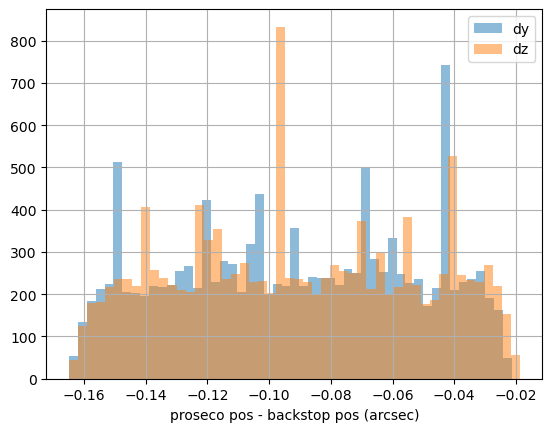

In [9]:
plt.hist(res['dy'], bins=50, alpha=0.5, label='dy');
plt.hist(res['dz'], bins=50, alpha=0.5, label='dz');
plt.grid()
plt.legend();
plt.xlabel('proseco pos - backstop pos (arcsec)');